In [1]:
# 필요한 라이브러리 import 하기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train.shape)
train.head()

(15035, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
# 테스트 데이터 파악하기
print(test.shape)
test.head()

(6468, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [5]:
# 결측값 확인하기
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

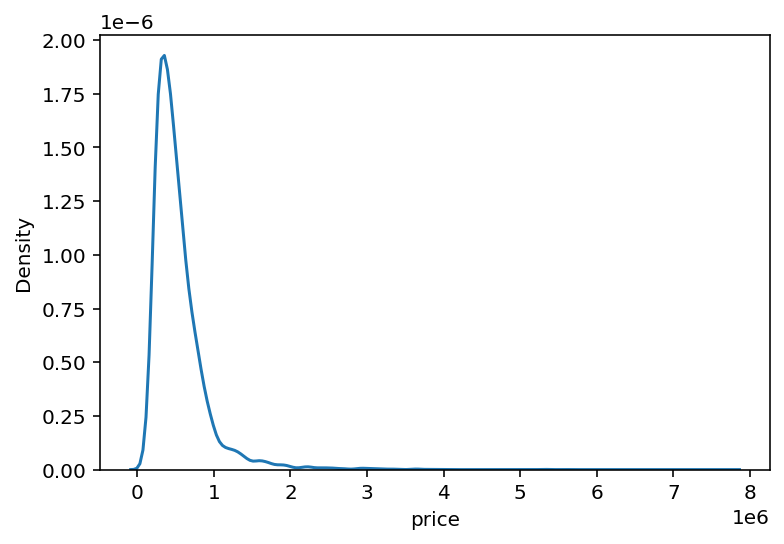

In [6]:
# 타겟값 price 분포 확인
sns.kdeplot(train['price'])
plt.show()

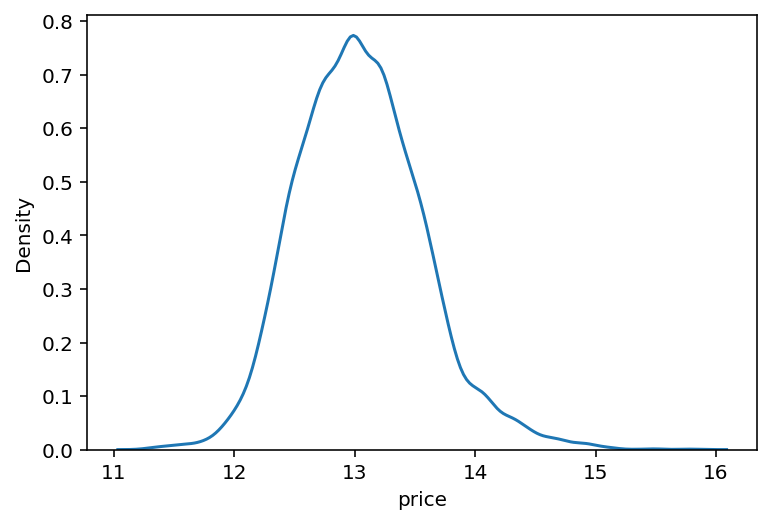

In [7]:
# 타겟값 로그 변환
train['price'] = np.log1p(train['price'])
sns.kdeplot(train['price'])
plt.show()

In [8]:
# 데이터 정규화 진행
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

In [9]:
# date 변수 수정
for df in [train, test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [10]:
# 필요한 다른 변수 생성
for df in [train, test]:
    # 화장실 포함 방 개수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    # 주거 공간 평수 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    # 전체 평수
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    # 전체 평수 대비 주거 공간 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    # 2015년 기준 주거 공간의 비율
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [11]:
# 지역별 평당 가격
train['per_price'] = train['price'] / train['sqft_total_size']
zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
train = pd.merge(train, zipcode_price, how='left', on='zipcode')
test = pd.merge(test, zipcode_price, how='left', on='zipcode')

for df in [train, test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

In [12]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,per_price,zipcode_mean,zipcode_var
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,5650,4.00,0.818803,7.074117,1.0,0.237168,0,1.740145,9.368147,1.214207
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,8062,3.00,0.721756,6.647688,1.0,0.337385,0,1.820290,9.257745,1.023549
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,7503,5.00,0.825489,7.427144,1.0,0.239904,0,1.769478,11.307711,0.826257
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,6819,5.25,0.843688,7.447751,1.0,0.328201,0,1.672824,10.626177,1.012780
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,9711,4.50,0.758837,6.966967,1.0,0.169910,0,1.806238,10.032009,1.002206


In [13]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zipcode_mean,zipcode_var
0,15035,20141209,3,2.25,7.852050,8.887791,2.0,0,0,3,...,1690,7639,5.25,0.883465,13.676905,0.574110,0.221233,1,19.243241,2.317027
1,15036,20141209,4,3.00,7.581210,8.517393,1.0,0,0,5,...,1360,5000,7.00,0.890086,13.772040,0.550478,0.272000,0,18.113257,2.389816
2,15037,20140512,4,4.50,8.598036,11.532051,1.0,0,0,3,...,4760,101930,8.50,0.745577,15.600098,0.551153,0.046699,0,25.872675,0.772245
3,15038,20150415,3,1.00,7.484930,8.918784,1.0,0,0,3,...,1780,8113,4.00,0.839232,13.551911,0.552315,0.219401,0,19.759625,2.053191
4,15039,20150312,3,2.50,7.544861,8.788898,2.0,0,0,3,...,2390,7570,5.50,0.858454,7.544861,1.000000,0.315720,0,11.947244,0.477170


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# RMSE 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [15]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020

# 모델 인스턴스를 생성한 후 models라는 리스트에 넣어줍니다.
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [16]:
train_columns = [c for c in train.columns if c not in ['id','price','per_price']]
y = train['price']

In [17]:
# 각각의 모델에 대해 RMSE값을 구하는 함수
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        # 학습 및 예측
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # 예측 결과의 rmse값을 데이터 프레임에 저장
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train[train_columns], y)

,RMSE
GradientBoostingRegressor,127534.735715
RandomForestRegressor,126696.042756
LGBMRegressor,110343.629763
XGBRegressor,108880.355258


In [18]:
# cross-validation
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train[train_columns].values)
    for model in models:
        print("{} CV score : {:.4f}".format(str(model), np.mean(cross_val_score(model, train[train_columns].values, y)), kf=kfold))

In [19]:
get_cv_score(models)

GradientBoostingRegressor(random_state=2020) CV score : 0.8792
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) CV score : 0.8947
LGBMRegressor(random_state=2020) CV score : 0.9019
RandomForestRegressor(random_state=2020) CV score : 0.8842


In [20]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results.head()

In [21]:
# 그리드 탐색으로 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [450, 500, 550, 600, 650, 700],
    'max_depth': [11, 13, 15, 17, 19],
    'num_leaves': [15, 31],
    'learning_rate': [0.05]
}

my_GridSearch(lightgbm, train[train_columns], y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
29,0.05,15,550,31,-0.025756,0.160488
31,0.05,15,600,31,-0.025758,0.160492
33,0.05,15,650,31,-0.025785,0.160579
35,0.05,15,700,31,-0.025796,0.160610
27,0.05,15,500,31,-0.025811,0.160657


In [22]:
# 서치 결과로 최적의 하이퍼파라미터 값 설정
lightgbm = LGBMRegressor(learning_rate=0.05, max_depth=15, n_estimators=550, num_leaves=31, random_state=random_state)

In [25]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    # 학습 및 예측
    model.fit(train, y)
    prediction = model.predict(test[train_columns])
    prediction = np.expm1(prediction)  # 원래 스케일로 되돌리기
    
    # 샘플 파일에 예측값 덮어쓰고 저장
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    return submission.head()

In [26]:
save_submission(lightgbm, train[train_columns], y, test, 'lgbm', rmsle='0.160488')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.160488.csv saved!


,id,price
0,15035,4.994740e+05
1,15036,4.861761e+05
2,15037,1.416237e+06
3,15038,3.086635e+05
4,15039,3.298405e+05


In [27]:
import os
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
%matplotlib inline

In [29]:
def haversine_array(lat2, lng2):
    lat1, lng1 = 47.63, -122.22
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    diffs = np.expm1(predictions) - np.expm1(labels)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('rmse_exp', np.sqrt(avg))

def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 6), grid_model.best_params_))
    return grid_model.best_estimator_

def zipcode_groupby(train, test, group_col, colname, agg_method) :
    new_colname = 'price_per'+'_'+colname
    #new_colname2 = colname+'mean'
    
    train[new_colname] = train['price']/train[colname]
    price_per_temp = train.groupby([group_col])[new_colname].agg(agg_method)
    price_per_temp.columns = ['{}_{}'.format(new_colname, m) for m in agg_method]
    price_per_temp = price_per_temp.reset_index()
    #price_per_temp.rename(columns={'mean':new_colname2}, inplace=True)
    train = pd.merge(train, price_per_temp, how='left', on=group_col)
    test = pd.merge(test, price_per_temp, how='left', on=group_col)
    
    del train[new_colname]
    
    return train, test

def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t

def category_feature_distribution(train, col, target='price'):
    fig, ax = plt.subplots(1, 2, figsize=(16,4))
    
    for c in sorted(train[col].unique()):
        sns.distplot(train.loc[train[col]==c, target], ax=ax[0])
    ax[0].legend(sorted(train[col].unique()))
    ax[0].set_title(f'{col} {target} distribution')

    sns.boxplot(x=col, y=target, data=train, ax=ax[1])
    ax[1].set_title(f'{col} vs {target}')
    
    plt.show()
    
def haversine_array_new(lat1_raw, lng1_raw, lat2, lng2):
    lat1, lng1 = lat1_raw, lng1_raw
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def haversine_array_low(lat2, lng2):
    lat1, lng1 = 47.382, -122.247
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [30]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
data = pd.merge(train, test, how='outer')

train_raw = train
train_len = len(train)

data['min_haver'] = np.nan
for i in range(len(data)) :
    temp_lat, temp_lng = data[['lat', 'long']].loc[i,'lat'], data[['lat', 'long']].loc[i,'long']
    temp_all_df = data.drop([i], 0)
    temp_coord_df = haversine_array_new(temp_lat, temp_lng, temp_all_df['lat'], temp_all_df['long'])
    temp_min = temp_coord_df.min()
    data.loc[i,'min_haver'] = temp_min

In [31]:
######## zipcode 라벨링
train = data.iloc[:train_len,:]
test = data.iloc[train_len:,:]

for df in [train, test] :
    df['zip_12'] = df['zipcode'].apply(lambda x : str(x)[2:4]).astype(int)

le = LabelEncoder()

le.fit(train['zipcode'])
le.fit(test['zipcode'])

train['zipcode'] = le.transform(train['zipcode'])
test['zipcode'] = le.transform(test['zipcode'])

train['sqft_total_size'] = train['sqft_above'] + train['sqft_basement'] # 총 주거 면적    
test['sqft_total_size'] = test['sqft_above'] + test['sqft_basement']

####### zipcode_groupby 단가 변수 생성
train['price_per_land_area'] = train['price'] / (train['sqft_living'])
price_per_ft = train.groupby(['zipcode'])['price_per_land_area'].agg({'mean', 'std', 'count'}).reset_index()
train = pd.merge(train, price_per_ft, how='left', on='zipcode')
test = pd.merge(test, price_per_ft, how='left', on='zipcode')
del train['price_per_land_area']

####### train, test set 지정

X_train = train.drop(['id', 'price'], 1)
y_train = train['price']
y_train = np.log1p(y_train)
X_test = test.drop(['id', 'price'], axis=1)

####### KMeans Clustering
km_n = 120
km = KMeans(n_clusters=km_n, random_state=2019)
km.fit(X_train[['lat', 'long']])#

######## 이외 Feature Engineering
for df in [X_train, X_test]:
    df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400) # 날짜 줄 세우기
    df['how_old'] = df['date'].apply(lambda x: x[:4]).astype(int) - df[['yr_built', 'yr_renovated']].max(axis=1) # 얼마나 됐는지 연식
    df['yr_built'] = df['yr_built'] - 1900 # 건축년도 1900년도로부터 얼마나 됐는지 
    
    # sqft 관련
    df['sqft_diff'] = df['sqft_living15'] - df['sqft_living']
    df['sqft_living_lot_diff'] = df['sqft_lot'] - df['sqft_living']
    del df['sqft_lot15'], df['yr_renovated'], df['sqft_lot'],df['date']
  
    
    # 방 관련
    df['sqft_bedrooms'] = df['sqft_total_size'] / (df['bedrooms'] + 1) # 방하나당 면적 : bedrooms가 0인 자료 꽤 있음 
    
    
    # KMeans 클러스터링
    km_col_name = 'km'+ '_' + str(km_n)
    df[km_col_name] = km.predict(df[['lat', 'long']])
    
    # 레벨 관련
    df['sum_level'] = df['grade'] + df['view'] + df['condition'] # 등급 총합
    df['multi_level'] = df['grade'] * (df['view']+1) * df['condition']
    
    df['condition_2'] = df['condition'].apply(lambda x : 0 if x < 3 else x)
    df['sum_level_2'] = df['view'] + df['condition_2'] + df['grade']
    
    del df['condition_2']
    
    df['low_cond']=df['condition'].apply(lambda x : 0 if x <= 2 else 1)
    df['low_view'] = df['view'].apply(lambda x : 0 if x == 0 else 1)
    df['low_bath'] = df['bathrooms'].apply(lambda x: 0 if x < 1 else 1)
    df['low_bed'] = df['bedrooms'].apply(lambda x : 0 if x ==1 else 1)
    df['low_grade'] = df['grade'].apply(lambda x : 0 if x <= 6 else 1)
    df['low_all'] = (df['low_cond'] + df['low_view']+df['low_bath'] + df['low_bed'] + df['low_grade']) + df['waterfront']
    
    del df['low_cond'], df['low_view'], df['low_bath'], df['low_bed'], df['low_grade']
   
    # 거리 관련
    df['haversine_dist']= haversine_array(df['lat'], df['long']) # 중심가로부터의 거리 (haversine_dist)
    df['haversine_dist_low'] = haversine_array_low(df['lat'], df['long'])


# 로그화
for i in ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_total_size', 'sqft_bedrooms'] :
    X_train[i] = np.log1p(X_train[i])
    X_test[i] = np.log1p(X_test[i])
    
X_train = X_train.drop([13522, 4123],0)
y_train = y_train.drop([13522, 4123],0)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print(len(X_train.columns), X_train.columns)
print([item for item in X_train.columns if item not in train_raw.columns])

33 Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'min_haver', 'zip_12',
       'sqft_total_size', 'mean', 'std', 'count', 'date(new)', 'how_old',
       'sqft_diff', 'sqft_living_lot_diff', 'sqft_bedrooms', 'km_120',
       'sum_level', 'multi_level', 'sum_level_2', 'low_all', 'haversine_dist',
       'haversine_dist_low'],
      dtype='object')
['min_haver', 'zip_12', 'sqft_total_size', 'mean', 'std', 'count', 'date(new)', 'how_old', 'sqft_diff', 'sqft_living_lot_diff', 'sqft_bedrooms', 'km_120', 'sum_level', 'multi_level', 'sum_level_2', 'low_all', 'haversine_dist', 'haversine_dist_low']


In [32]:
X_train['price'] = y_train
km2 = KMeans(n_clusters=120, random_state=2019)
km2.fit(X_train[['price', 'km_120']])
X_train['km_pre'] = km2.predict(X_train[['price', 'km_120']])
X_train.drop('price', 1, inplace=True)
X_train_km_pre = X_train[['km_120', 'km_pre']].groupby('km_120')['km_pre'].mean().reset_index()
X_test = X_test.merge(X_train_km_pre, how='left', on='km_120')

In [33]:
%%time
dtrain = lgb.Dataset(X_train, label=y_train)
dtest  = lgb.Dataset(X_test)

lgb_params = {
    'boosting_type': 'gbdt',
    'objective':'regression',
    'num_leave' : 1,
    'learning_rate' : 0.03,
    'max_depth' : 6,
    'colsample_bytree' : 0.4,
    'subsample' : 0.4,
    'max_bin' : 80,
    'gpu_id':0,         
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'refit':True,
    'metric' : 'rmse',
    'seed' : 2019
}

cv_lgb_output = lgb.cv(lgb_params, dtrain, num_boost_round=5000, nfold=5, early_stopping_rounds=200, verbose_eval=100,stratified=False)

print('best_num_rounds :',len(cv_lgb_output['rmse-mean']))
print('best_cv_score :', cv_lgb_output['rmse-mean'][-1])

best_num_rounds = len(cv_lgb_output['rmse-mean'])

model_lgb = lgb.train(lgb_params, dtrain, num_boost_round=best_num_rounds)
lgb_pred_log = model_lgb.predict(X_test)
lgb_pred = np.expm1(lgb_pred_log)

[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[Ligh

[14:19:07] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:07] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:19:07] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:07] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:19:07] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:s

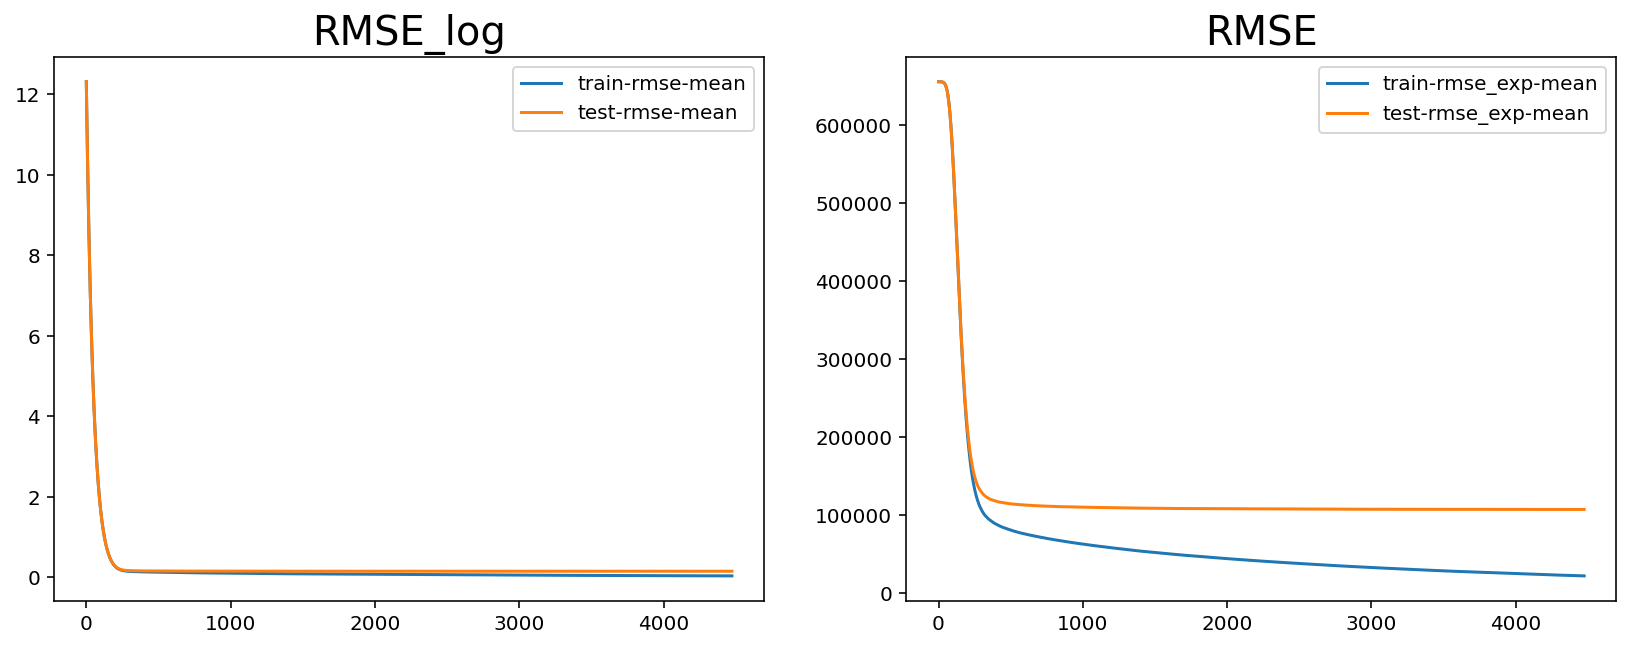

In [34]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',        
    'silent': True,               
    'seed' : 1984
}



# transform
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

# cross validation
cv_output = xgb.cv(xgb_params,
                   dtrain,                        
                   num_boost_round=5000,         
                   early_stopping_rounds=150,    
                   nfold=5,                      
                   verbose_eval=100,             
                   feval=rmse_exp,               
                   maximize=False,
                   show_stdv=False,              
                   )

# scoring
best_rounds = cv_output.index.size
score = round(cv_output.iloc[-1]['test-rmse_exp-mean'], 2)

print(f'\nBest Rounds: {best_rounds}')
print(f'Best Score: {score}')

model = xgb.train(xgb_params, dtrain, num_boost_round=best_rounds)
xgb_pred_log = model.predict(dtest)
xgb_pred = np.expm1(xgb_pred_log)

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot(ax=ax1)
ax1.set_title('RMSE_log', fontsize=20)
cv_output[['train-rmse_exp-mean', 'test-rmse_exp-mean']].plot(ax=ax2)
ax2.set_title('RMSE', fontsize=20)

plt.show()

In [35]:
ensemble_pred = np.vstack([lgb_pred, xgb_pred]).mean(0)
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
submission = pd.DataFrame(data = {'id': test['id'], 'price': ensemble_pred})
submission.to_csv(join(data_dir,'submission_ensemble_2.csv'), index=False)

### 마치며
* 데이터 전처리를 위한 꽤 많은 작업이 필요함을 느낌
* 비록 목표치에 도달하진 못 하였더라도, 구글 검색을 활용하여 XG와 LGBM 모델을 통해 바라던 결과 확인함
* 이와 같은 엔지니어링을 통해 더 좋은 결과를 도출하기 위해 아직도 부족하여 더욱 많은 공부가 필요하다고 생각함